In [1]:
import pandas as pd
import dask as dd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


In [2]:
sns.set()

### Extract car industry entries

In [19]:
df = pd.read_csv('../data.csv')


/var/folders/5h/tc1b2dhx483_cx6pj09_pyc80000gn/T/ipykernel_55119/1484362809.py:1: DtypeWarning: Columns (3,4,7,8,11,12,14,15,16,19,45,46,49,56,69,83,95,98,99,100,104,108,109,119,120,121,122,123,124,125,127,128,129,141,143,144,145,146,147,148,155,188,217,218,219,220,221,222,223,224,226,229,232,233,234,235,236,237,238,239,240,243,244,245,246,248,249,250,252) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data.csv')


In [38]:
df = df[df['psic'].notna()] #drop 45 NaN participant SIC, fix the issue by not solving it
autoDF = df[df['psic'].str.contains('3711')] #Create df who have at least one participant in the automotive industry with SIC: 3711
autoDF.to_csv('autodf.csv') #create csv sample

## Work on car industry DF

In [2]:
autoDF = pd.read_csv('autodf.csv')

### Clean data

In [3]:
autoDF = autoDF.drop('Unnamed: 0.1', axis=1)
autoDF.rename(columns={"Unnamed: 0": "og_index"},inplace=True)

count    3683.000000
mean        2.315775
std         0.831181
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        13.000000
Name: nump, dtype: float64


<AxesSubplot:>

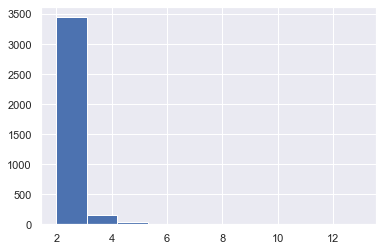

In [132]:
print(autoDF['nump'].describe())
autoDF['nump'].hist()

## H1: Auto industry incumbents tend to form alliances with new entrants introducing the EV technology rather than other incumbents

In [46]:
variables = ["id","activity", "activityc", "da", "jvinc", "jvindustry", "jvstatus", "p", "pbl", "pbuss", "psic", "psicp", "nump", "PBUSSOURCE".lower()]
honeDF = autoDF[variables]
honeDF = honeDF[honeDF['psicp'].str.contains('3711')] #Filter alliances where there is >= 1 participant with {Participant SIC Primary}(PSICP) == car industry

In [47]:
pattern = r'\\n' #Regex pattern to split name

for n in range(1, (int(honeDF["nump"].max()) + 1)): 
	honeDF['p' + str(n) + "name"] =  honeDF['p'].str.split(pattern, expand=True)[n-1] #Create seperate columns for each possible participant

	honeDF["p" + str(n) + "sicp"] = honeDF['psicp'].str.split(pattern, expand=True)[n-1] #Create seperate placeholder columns to split participant SIC codes


In [40]:
#Turn SICs to numeric

# cols = honeDF.filter(regex='p\d+sicp', axis=1).columns #individual primary sic codes columns

# honeDF[cols] = honeDF[cols].apply(pd.to_numeric, errors="coerce")

In [62]:
honeDF['da'] = pd.to_datetime(honeDF['da'],format="%m%Y") #turn Announcement Date to datetime

<AxesSubplot:xlabel='da,da'>

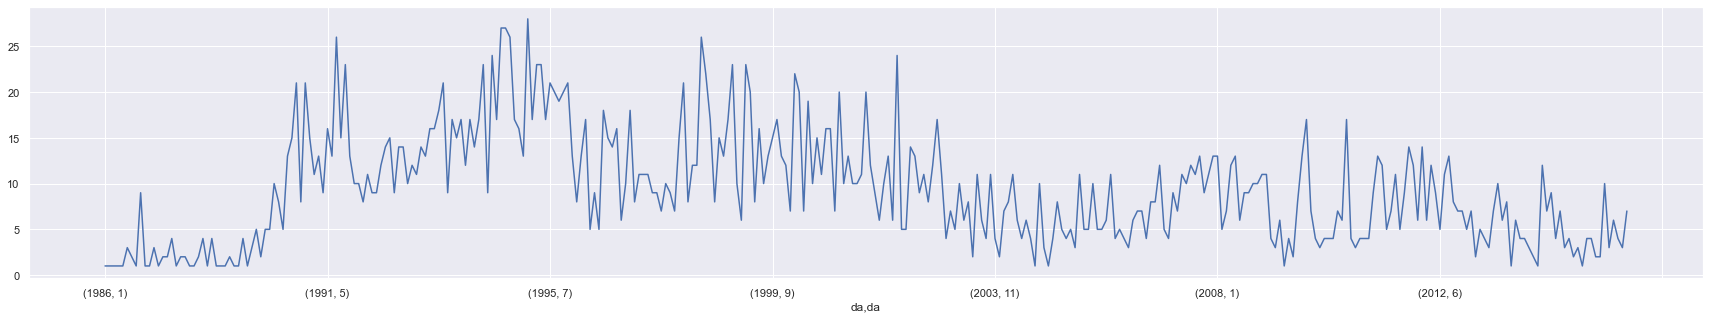

In [189]:
#Line graph of alliance account per monht/year
honeDF['da'].groupby([honeDF['da'].dt.year, honeDF['da'].dt.month]).agg('count').plot(figsize=(30,5))

### Define timeperiod 5Y - 2007 - 5Y

In [119]:
focusDF = honeDF[(honeDF['da'] >= '2002-01-01') & (honeDF['da'] <= '2012-12-31')]
focusDF.set_index('da', inplace=True, drop=True)

<AxesSubplot:xlabel='da'>

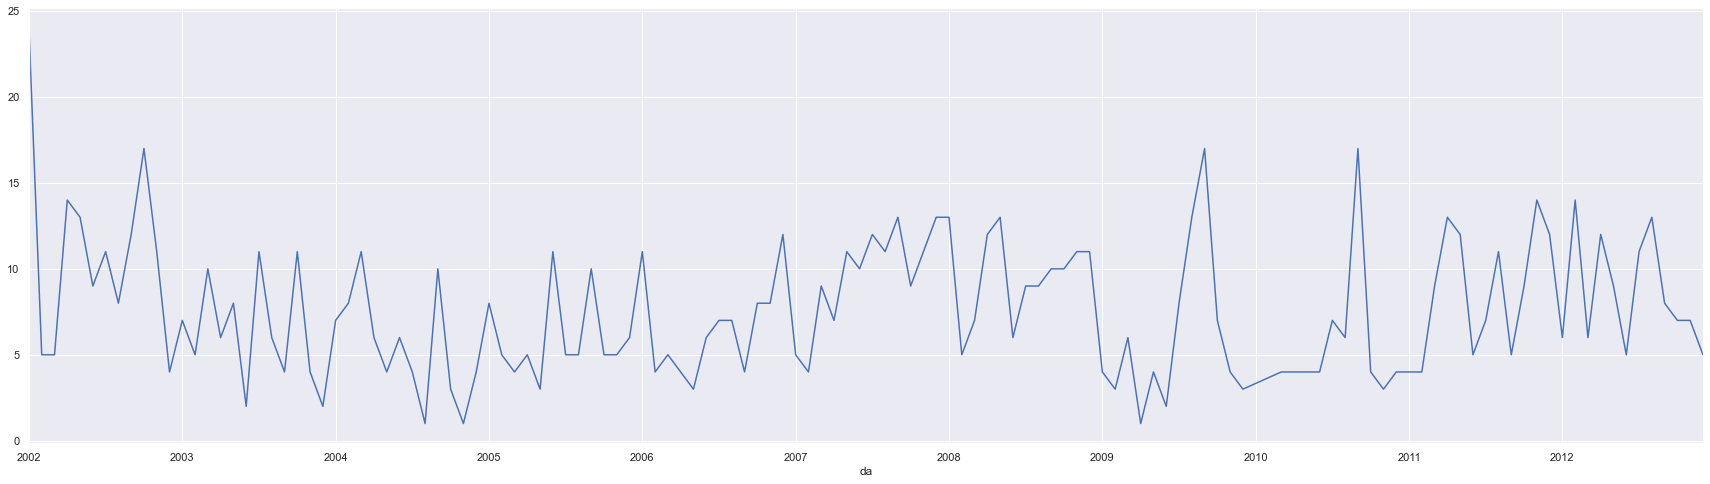

In [29]:
focusDF['id'].groupby(focusDF.index.to_period("M")).agg('count').plot(figsize=(30,8))



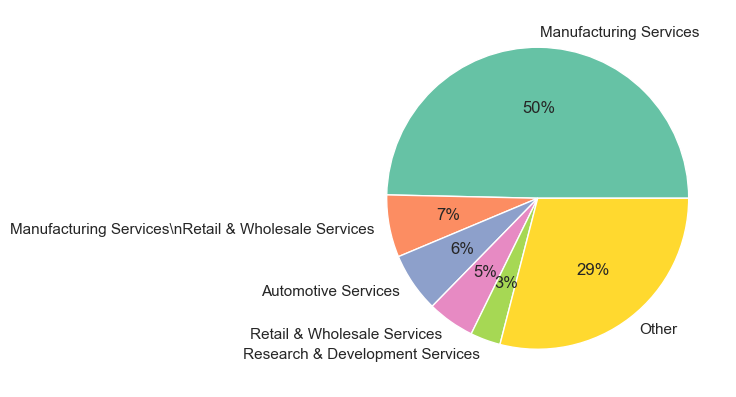

In [194]:
topFiveActiv = focusDF['activity'].value_counts()[:5] #Get top 5 most frequent activities
otherActiv = pd.Series({"Other":focusDF['activity'].value_counts()[5:].sum()}) #Get count of the rest of activities into a Series

activCounts = pd.concat([topFiveActiv, otherActiv]) #Concat the two series

colors = sns.color_palette('Set2')
plt.figure(figsize=(10,5), dpi=100)
plt.pie(activCounts, labels=activCounts.index, colors=colors, autopct='%.0f%%')
plt.show()

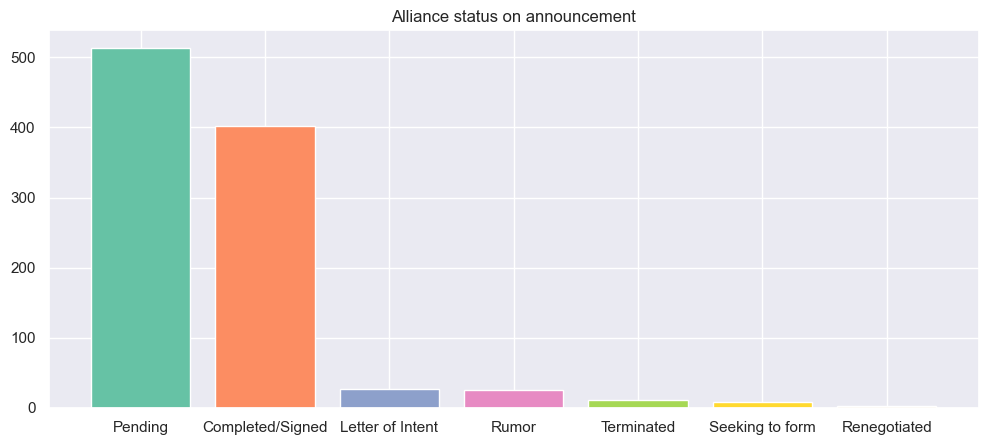

In [221]:
allianceStatus = focusDF['jvstatus'].groupby(focusDF['jvstatus']).agg('count').sort_values(ascending=False)

plt.figure(figsize=(12,5), dpi=100)
plt.title('Alliance status on announcement')
plt.bar(allianceStatus.index, allianceStatus.values, color=colors)
plt.show()

### Define new entrant / incumbent alliance

In [ ]:
cols = honeDF.filter(regex='p\d+sicp', axis=1).columns #Get columns of individual participant SICs

focusDF['pdynamic'] = (focusDF[cols]=='3711').sum(axis=1) > 1 #Flag True for alliances consisting of more than one automotive incumbent
focusDF['pdynamic'] = focusDF['pdynamic'].map({True: "incumbent", False: "new_entrant"}) #Turn tha above from boolean to string


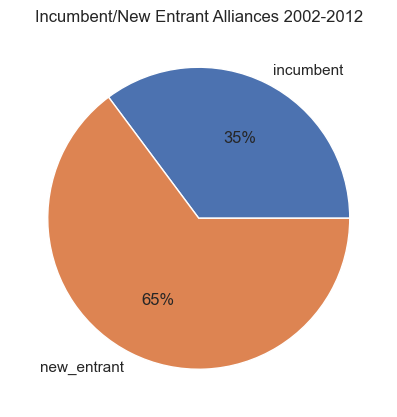

In [251]:
inc_newentr_share = focusDF['pdynamic'].groupby(focusDF['pdynamic']).agg('count')

plt.figure(figsize=(12,5), dpi=100)
plt.title('Incumbent/New Entrant Alliances 2002-2012')
plt.pie(inc_newentr_share, labels=inc_newentr_share.index, autopct='%.0f%%')
plt.show()

In [252]:
focusDF.to_csv('JV_data_2002-2012.csv')

In [16]:
focusDF = pd.read_csv('JV_data_2002-2012.csv')
focusDF['da'] = pd.to_datetime(focusDF['da'])
focusDF = focusDF.set_index('da')


In [78]:
ctdf = (focusDF['pdynamic']
		.groupby([focusDF.index.to_period("M"), focusDF['pdynamic'].values])
		.count()
		).reset_index().rename(columns={'level_1': 'categorical', 'pdynamic': 'ct'})

<Figure size 1200x1900 with 0 Axes>

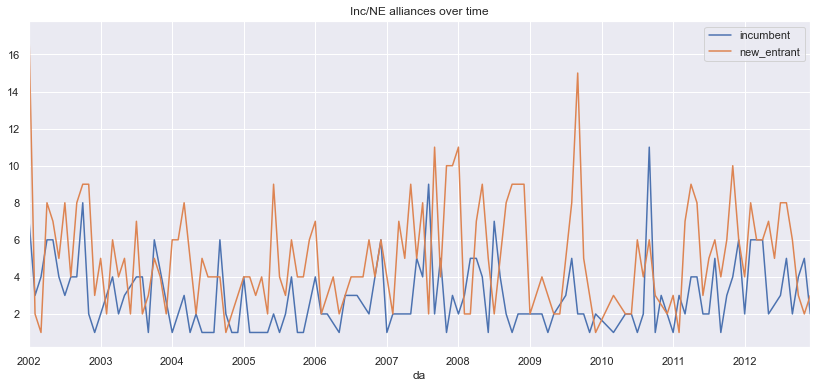

In [109]:
plt.figure(figsize=(12,19), dpi=100)

fig, ax = plt.subplots()

# key gives the group name (i.e. category), data gives the actual values
for key, data in ctdf.groupby('categorical'):
    data.plot(x='da', y='ct', ax=ax, label=key, figsize=(14, 6), title='Inc/NE alliances over time')



In [129]:
pd.to_datetime('2007-06-02')

Timestamp('2007-06-02 00:00:00')

### Calculate distance from discontinuity

In [137]:
focusDF['disc_dist'] = abs((pd.to_datetime("02/06/2007", format="%d/%m/%Y") - focusDF.index).days)

<AxesSubplot:xlabel='pdynamic', ylabel='disc_dist'>

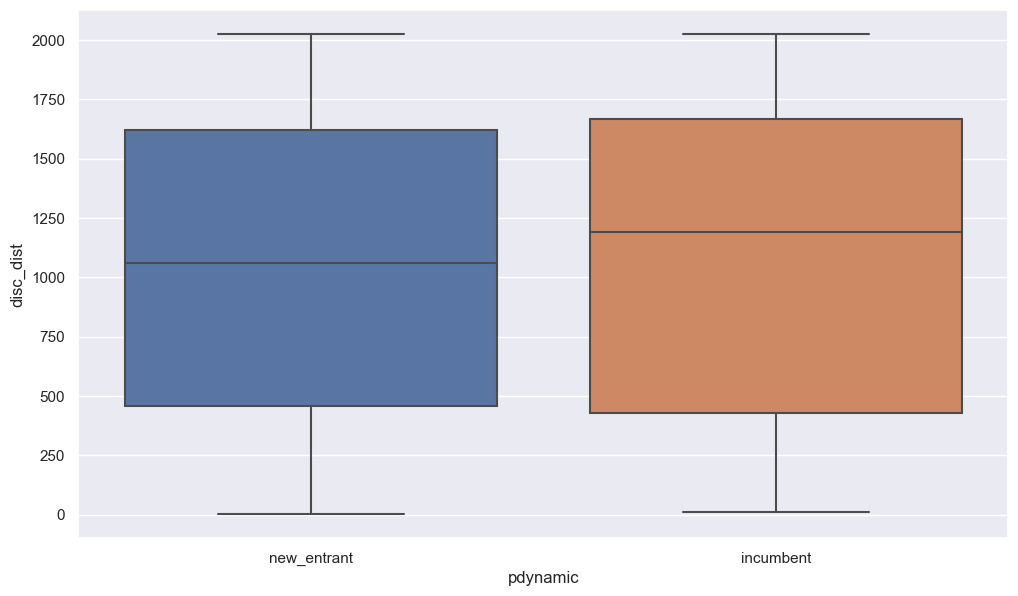

In [143]:
plt.figure(figsize=(12,7), dpi=100)

sns.boxplot(data=focusDF, y='disc_dist', x='pdynamic')

In [144]:
focusDF.to_csv('JV_data_2002-2012.csv')

## H2: Automotive industry incumbents tend to form strategic partnerships with new entrants rather than acquire them.

In [28]:
prepedDF = pd.read_csv('JV_data_2002-2012.csv')

In [11]:
ogDF = pd.read_csv('autodf.csv')

In [35]:
cols = ['id', 'jvf', 'jvtype']
extra_vars = ogDF[cols]
prepedDF = pd.merge(prepedDF, extra_vars, how='left', on='id')

In [41]:
prepedDF.to_csv("jvf_data.csv", index=False)

In [49]:
#Basic prep
jvfDF = pd.read_csv("jvf_data.csv")
jvfDF['da'] = pd.to_datetime(jvfDF['da'])
jvfDF = jvfDF.set_index('da', drop=True)

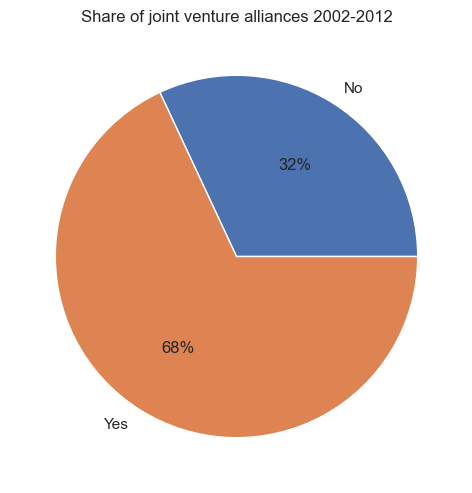

In [51]:
jvf_share = jvfDF['jvf'].groupby(jvfDF['jvf']).agg('count')

plt.figure(figsize=(12,6), dpi=100)
plt.title('Share of joint venture alliances 2002-2012')
plt.pie(jvf_share, labels=jvf_share.index, autopct='%.0f%%')

plt.show()

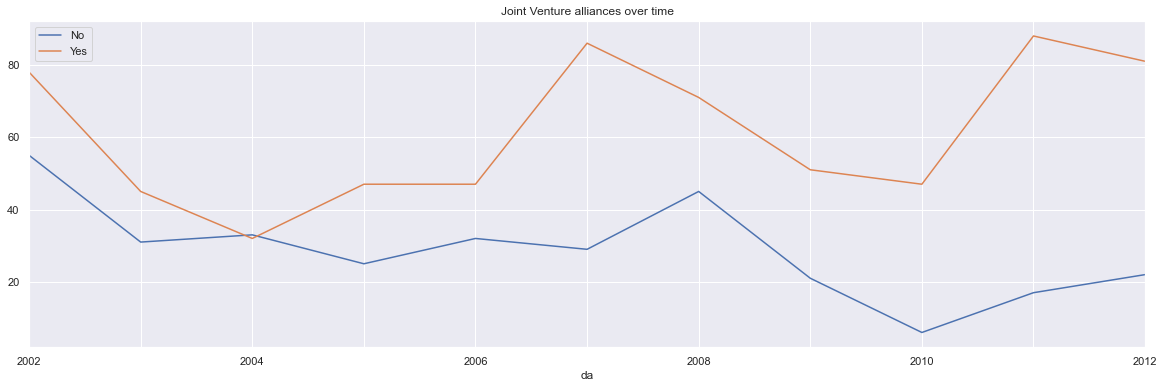

In [72]:
jvf_otimeY = (jvfDF['jvf']
		.groupby([jvfDF.index.to_period("Y"), jvfDF['jvf'].values])
		.count()
		).reset_index().rename(columns={'level_1': 'categorical', 'jvf': 'count'})

fig, ax = plt.subplots()
# key gives the group name (i.e. category), data gives the actual values
for key, data in jvf_otimeY.groupby('categorical'):
    data.plot(x='da', y='count', ax=ax, label=key, figsize=(20, 6), title='Joint Venture alliances over time')
    plt.xticks(jvf_otimeY['da'])

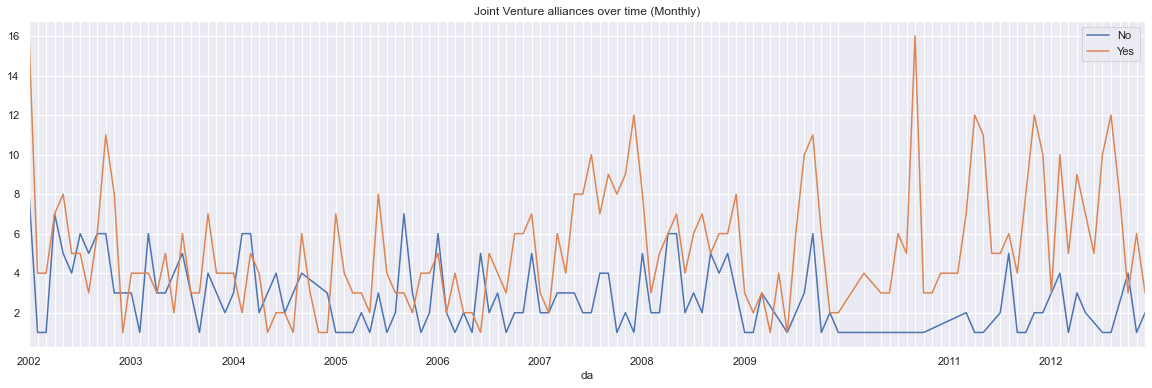

In [75]:
jvf_otimeM = (jvfDF['jvf']
		.groupby([jvfDF.index.to_period("M"), jvfDF['jvf'].values])
		.count()
		).reset_index().rename(columns={'level_1': 'categorical', 'jvf': 'count'})

fig, ax = plt.subplots()
# key gives the group name (i.e. category), data gives the actual values
for key, data in jvf_otimeM.groupby('categorical'):
    data.plot(x='da', y='count', ax=ax, label=key, figsize=(20, 6), title='Joint Venture alliances over time (Monthly)')
    plt.xticks(jvf_otimeM['da'])